In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random

In [3]:
G = nx.DiGraph() # Grafo direcionado

In [ ]:
# Limpando a pasta twitter para ter apenas as arestas
for arquivo in os.listdir("twitter"):
    extensao = os.path.splitext(arquivo)[1]
    if extensao in ['.circles', '.egofeat', '.feat', '.featnames']:
        os.remove(os.path.join("twitter", arquivo))

In [6]:
data = "twitter"

for file in os.listdir(data):
    if file.endswith(".edges"):
        node_id = file.split(".")[0] # Node Id do nome do arquivo
        file_path = os.path.join(data, file)

        with open(file_path, "r") as f:
            for line in f:
                connection_node = line.strip()
                if connection_node:
                    G.add_edge(node_id, connection_node) # Adiciona a aresta ao grafo entre o nó e o nó de conexão

print(f"Grafo criado com {G.number_of_nodes()} nós e {G.number_of_edges()} arestas.")
# Salva o grafo em formato GEXF no diretorio atual do projeto
nx.write_gexf(G, "grafo.gexf")

Grafo criado com 1668858 nós e 2286909 arestas.


In [ ]:
def subgrafo_por_arestas(G, num_edges=2000):
    """Seleciona um subconjunto aleatório de arestas e mantém os nós conectados a elas."""
    amostra_nos = random.sample(list(G.edges()), min(num_edges, len(G.edges())))
    
    # Criar um subgrafo apenas com as arestas escolhidas
    G_sample = nx.Graph()
    G_sample.add_edges_from(amostra_nos)

    return G_sample

# Defina quantas arestas deseja manter
qtd_arestas = 2000
G_sample = subgrafo_por_arestas(G, num_edges=qtd_arestas)

print(f"Grafo amostrado com {G_sample.number_of_nodes()} nós e {G_sample.number_of_edges()} arestas.")


Grafo amostrado com 2659 nós e 2000 arestas.


In [24]:
# Detecção de comunidade com louvain ou girvan-newman
# Início do relatório no overleaf

def girvan_newman(G):
    """ Detecção de comunidades usando o algoritmo Girvan-Newman."""
    generator = nx.algorithms.community.girvan_newman(G)
    comunidades = []
    for comunidade in next(generator):
        comunidades.append(list(comunidade))
    print(f"Gerador Girvan-Newman: {len(comunidades)} comunidades detectadas.")

    return comunidades

In [23]:
def louvain(G):
    """ Detecção de comunidades usando o algoritmo Louvain."""
    partition = nx.algorithms.community.louvain_communities(G)
    # Mapeamento de nós para comunidades
    comunidades = [list(comunidade) for comunidade in partition]
    print(f"Gerador Louvain: {len(comunidades)} comunidades detectadas.")

    return comunidades

In [25]:
comunidades_girvan_newman = girvan_newman(G_sample)
comunidades_louvain = louvain(G_sample)

# Cores para plotar os gráficos
paleta = sns.color_palette('pastel', max(len(comunidades_girvan_newman), len(comunidades_louvain)))
mapa_cores = {i: paleta[i] for i in range(len(paleta))}

cores_girvan_newman = []
for vertice in G_sample:
    for idx, grupo in enumerate(comunidades_girvan_newman):
        if vertice in grupo:
            cores_girvan_newman.append(mapa_cores[idx])
            break
    else:
        cores_girvan_newman.append("gray")

cores_louvain = []
for vertice in G_sample:
    for idx, grupo in enumerate(comunidades_louvain):
        if vertice in grupo:
            cores_louvain.append(mapa_cores[idx])
            break
    else:
        cores_louvain.append("gray")

Gerador Girvan-Newman: 660 comunidades detectadas.
Gerador Louvain: 659 comunidades detectadas.


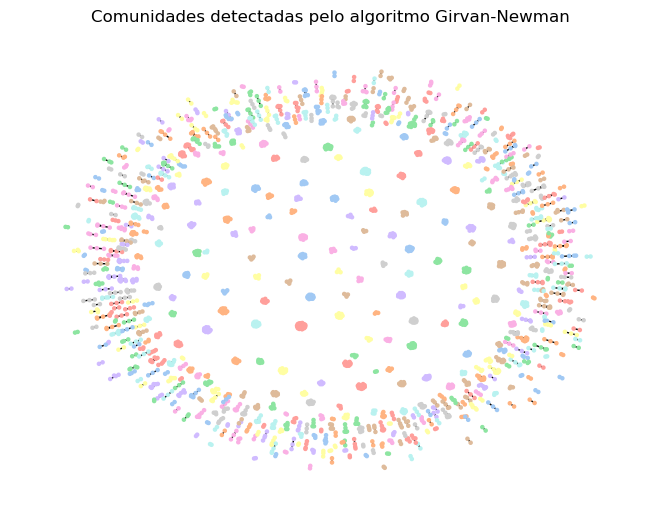

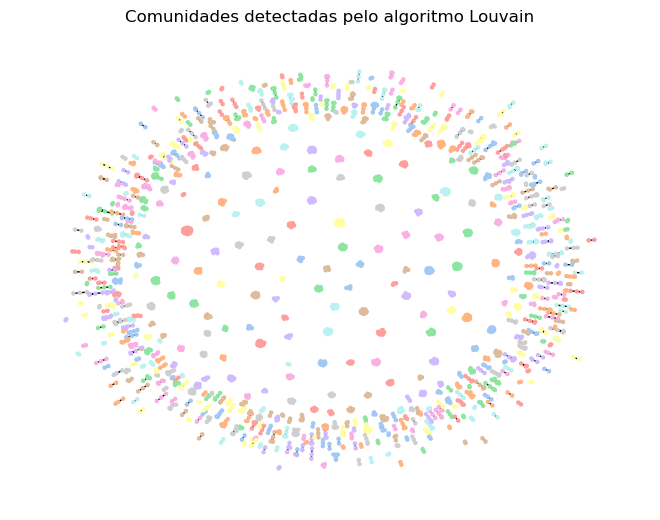

In [26]:
nx.draw(G_sample, node_color=cores_girvan_newman, node_size=5)
plt.title("Comunidades detectadas pelo algoritmo Girvan-Newman")
plt.show()

nx.draw(G_sample, node_color=cores_louvain, node_size=5)
plt.title("Comunidades detectadas pelo algoritmo Louvain")
plt.show()
